In [1]:
import os
import numpy as np
import numpy.random as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

# %config InlineBackend.figure_format='retina'
# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True

# Mac用フォント設定
if not flag_win32:
    font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font6/f7be88d8810a72a553ddc7ba14c15aff10ffc581.asset/AssetData/Osaka.ttf'
    font_prop = font_manager.FontProperties(fname=font_path)
    matplotlib.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.family'] = 'Osaka'

In [2]:
color_dict = {0: 'r', 1: 'g', 2: 'b'}

findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans.


check:  0 [0.2 0.5] [[0.1   0.085]
 [0.085 0.1  ]] 0.0027750000000000014
check:  1 [1.2 0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.0027750000000000014
check:  2 [2.  0.5] [[0.1   0.085]
 [0.085 0.1  ]] 0.0027750000000000014


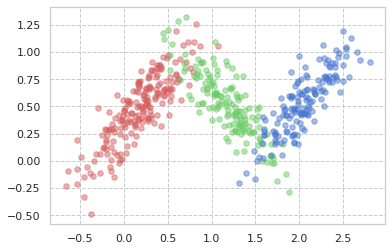

In [3]:
D = 2
K = 3
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(71)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

init mu:
 [[ 0.62943418  0.32095161]
 [-0.58760387  0.84842258]
 [ 1.78964936  0.32160232]]


Text(0.5, 1.0, 'initial state')

findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans.


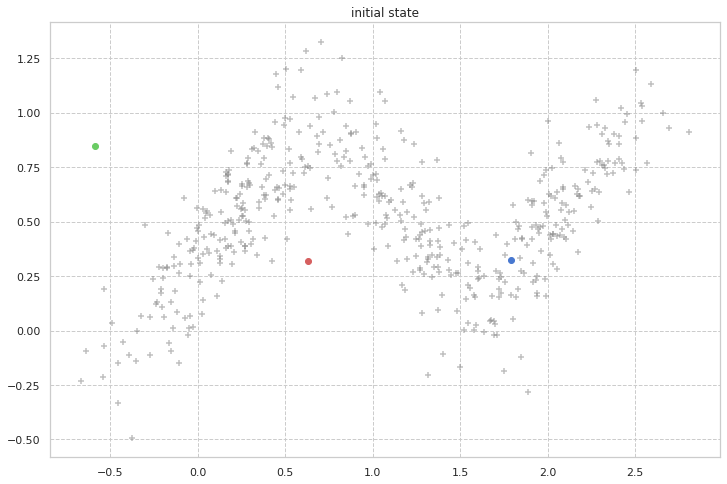

In [4]:
# initialize mu
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K) ]
print('init mu:\n', mu)

# visalize for check
plt.figure(figsize=(12,8))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")

for i in range(3):
    plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
plt.title('initial state')

In [5]:
# for _iter in range(100):
def animate(nframe):
    global mu
    print('nframe:', nframe)
    plt.clf()
    
    if nframe <= 3:
        print('initial state')
        plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
        for i in range(3):
            plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
        plt.title('initial state')
        return

    # Step 1
    # calculate nearest mu[k]
    r = np.zeros(N)
    for i in range(N):
        r[i] = np.argmin([np.linalg.norm(data[i]-mu[k]) for k in range(K)])

    # Step 2
    cnt = dict(Counter(r))
    N_k = [cnt[k] for k in range(K)]
    mu_prev = mu.copy()
    mu = np.asanyarray([np.sum(data[r == k],axis=0)/N_k[k] for k in range(K)])
    diff = mu - mu_prev
    print('diff:\n', diff)

    # visualize
    #plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=color_dict[r[i]], alpha=0.5, marker="+")

    for i in range(K):
        ax = plt.axes()
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8,head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
    plt.title("iter:{}".format(nframe))
    
    if np.abs(np.sum(diff)) < 0.0001:
        plt.title('mu is converged.')
    else:
        plt.title("iter:{}".format(nframe))

nframe: 0
initial state
nframe: 0
initial state
nframe: 1
initial state
nframe: 2
initial state
nframe: 3
initial state
nframe: 4
diff:
 [[-0.14720058  0.27697765]
 [ 0.29848565 -0.69664001]
 [ 0.05685036  0.14692699]]


<ipython-input-5-58e288aea57f>:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


nframe: 5
diff:
 [[ 0.06950521  0.08688548]
 [ 0.12803912  0.01170274]
 [-0.02302794 -0.00251512]]
nframe: 6
diff:
 [[ 0.04708575  0.02418917]
 [ 0.05488157  0.05488949]
 [ 0.00283139 -0.00053478]]
nframe: 7
diff:
 [[ 0.05096011  0.01245199]
 [ 0.03674644  0.0297716 ]
 [ 0.01946525 -0.00463088]]
nframe: 8
diff:
 [[ 0.03287941  0.0128977 ]
 [ 0.03177296  0.02500753]
 [ 0.00555113 -0.00128395]]
nframe: 9
diff:
 [[0.05346943 0.00458939]
 [0.03164879 0.03982927]
 [0.00898835 0.00147173]]
nframe: 10
diff:
 [[ 0.03207749 -0.00444306]
 [ 0.01183645  0.01575871]
 [ 0.01143424  0.00015237]]
nframe: 11
diff:
 [[ 0.04040346 -0.01048771]
 [ 0.01125388  0.01120005]
 [ 0.02314092 -0.00027676]]
nframe: 12
diff:
 [[ 0.02500529 -0.01118491]
 [ 0.00564555  0.00926624]
 [ 0.0151707   0.00154285]]
nframe: 13
diff:
 [[ 0.0177174  -0.00473519]
 [ 0.00738382  0.00582635]
 [ 0.00904419  0.00128751]]
nframe: 14
diff:
 [[ 0.02364936 -0.00879548]
 [ 0.007126    0.00623989]
 [ 0.01535144  0.00175121]]
nframe: 15


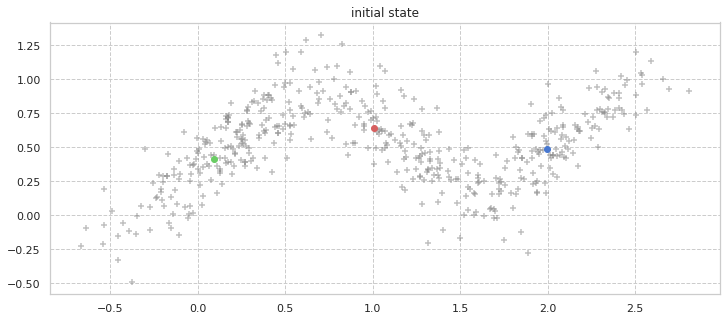

In [8]:
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=40)
anim.save('k-means_anim.gif', writer='pillow', fps=3, dpi=128)